######################################################################################################
# STAGE 2 - Analysis for 2 classes, title+content only
######################################################################################################


In [ ]:
# HOW TO IMPROVE MODELS?

### 1: DONE IN THIS NOTEBOOK
# # try to improve prediction for left bottom corner (false negatives)
# PARAMETER TUNING (e.g. num_boost_rounds)
# --> improves results a lot


### 2: DONE IN THIS NOTEBOOK
# use class_weights
# class 1: weight it 1,38 times
# done for logistic regression, passive aggressive classifier, SGD, LightGBM

# LogReg, PassiveAggressive, SGD: as attributes (class_weight=class_weights)

# LightGBM: in params 

# --> does not really improve results 
# --> test whether it changes in combination wih oversampling 


### 3: done in Notebook "Elisa_Report2_Modeling_Stage2_randomoversample
# --> using OverSample to deal with slightly unbalanced dataset
# Random Oversampling (RandomOverSampler) and SMOTE (SMOTE)
# not much of an improvement


### 4: done in Notebook "Elisa_Report2_Modeling_Stage3"
# Cross Validation (Stage 3)


### 5: done in Notebook "Elisa_Report2_Modeling_Stage3"
# compare different vectorizing methods


In [ ]:

##########################
## STAGE 2 - Analysis for 2 classes, title+content only
##########################

## We kept only two labels for further classification modeling:
# 0: articles from reliable sources
# 1: articles from unreliable sources

# USED PRE-PROCESSED DATASET: strats12_all_cleaned.pkl
# LOAD AS DF12
# --> contains 126.335 rows after pre-processing (2 classes)

# 0.0    73271
# 1.0    53084


#########
# Pre-Processing Steps:
# delete label "2: mixed"
# Create dataframe with title+content variables only
# remove stop words
# vectorize text (TF-IDF)
#########



# We only used title + content (vectorized)
# trial of boosting and 3 more complex models


# MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression****

# 5) Random Forest   --> takes very long! 
# 6) Passive Aggressive Classifier****

# 7) LightGBM
# 8) CatBoost
# 9) XGBoost

# 10) Stochastic Gradient Descent (SGD)****

# ****: very good results


# Import libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
# from sqlalchemy import create_engine
# import sqlalchemy as 
import sqlite3
import nltk
from nltk.tokenize import word_tokenize


# Load dataset + Pre-Processing

In [3]:
df12 = pd.read_pickle("strats12_all_cleaned.pkl")

In [4]:
df12.head(2)

,id,source,title,content,url,published_utc,label,factuality,questionable-source,conspiracy-pseudoscience,pro-science
0,21stcenturywire--2022-04-26--An Unsettling Rea...,21stcenturywire,An Unsettling Realization: ‘Mask Zealots are S...,It’s been noted how the fanatical nature of ma...,https://21stcenturywire.com/2022/04/26/an-unse...,1650983484,1.0,2.0,0.0,1.0,0.0
1,21stcenturywire--2022-04-24--Episode #416 – ‘S...,21stcenturywire,Episode #416 – ‘Soldiers of Fortune’ with gues...,Episode #416 of SUNDAY WIRE SHOW resumes this ...,https://21stcenturywire.com/2022/04/24/episode...,1650823248,1.0,2.0,0.0,1.0,0.0


In [5]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170099 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        170099 non-null  object 
 1   source                    170099 non-null  object 
 2   title                     170099 non-null  object 
 3   content                   170099 non-null  object 
 4   url                       170099 non-null  object 
 5   published_utc             170099 non-null  int64  
 6   label                     170099 non-null  float64
 7   factuality                170099 non-null  float64
 8   questionable-source       170099 non-null  float64
 9   conspiracy-pseudoscience  170099 non-null  float64
 10  pro-science               170099 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 15.6+ MB


In [6]:
# inspect labels
df12["label"].value_counts()

# slightly unbalanced


0.0    73271
1.0    53084
2.0    43744
Name: label, dtype: int64

In [7]:
### DELETE 2 in labels (delete 43744 rows)
df12 = df12[df12["label"] != 2]


In [8]:
# inspect labels
df12["label"].value_counts()

# 0.0    73271
# 1.0    53084

0.0    73271
1.0    53084
Name: label, dtype: int64

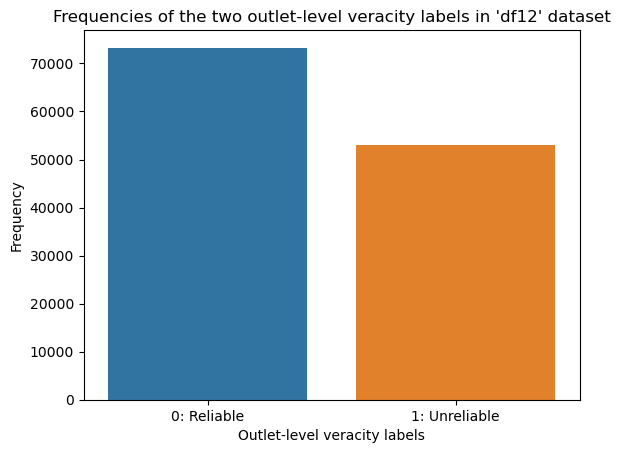

In [9]:
# barplot of labels
sns.countplot(x = "label", data = df12)
plt.xticks(np.arange(2),["0: Reliable", "1: Unreliable"])
plt.ylabel("Frequency")
plt.xlabel("Outlet-level veracity labels")
plt.title("Frequencies of the two outlet-level veracity labels in 'df12' dataset")
plt.show();


In [10]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   label                     126355 non-null  float64
 7   factuality                126355 non-null  float64
 8   questionable-source       126355 non-null  float64
 9   conspiracy-pseudoscience  126355 non-null  float64
 10  pro-science               126355 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.6+ MB


# Remove Stop Words 

In [11]:
import nltk
from nltk.corpus import stopwords

# Download stopwords corpus if not already downloaded
nltk.download('stopwords')

# Load the stopwords
stop_words = set(stopwords.words('english'))  # You can choose a different language if needed

# Update stop words variable
# stop_words.update([",", "."])

additional_words = ["?", "!", ".", ",", ":", ";", "-", "--", "...", '"', "'"]
stop_words.update(set(additional_words))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nutzer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# show stop words
print(stop_words)


{'a', "weren't", "that'll", 'off', 'further', 'where', 'mustn', 'only', 'herself', 'just', 'now', "haven't", 'and', 's', 'me', 'at', 'for', 'but', "mustn't", 'you', "hasn't", 'o', "'", 'she', 'them', '.', 'our', 'his', 'wouldn', 'being', 'hasn', 'on', 'which', 'will', 'by', 'yourselves', 'any', '...', 'as', "wasn't", 'my', 'your', 'won', 'same', 'be', 'from', 'both', ':', 'have', 're', 'down', "aren't", 'again', 'through', "won't", "it's", "shouldn't", 'whom', 'into', 'during', 'while', 'shouldn', 'am', 'has', 'own', 'with', 'is', 'himself', "shan't", 'when', 'myself', 'are', 'doesn', 'themselves', 'of', "hadn't", 'no', 'ours', "isn't", 'ourselves', 'yourself', 'against', 'or', 'once', 'very', "you'll", "don't", 'aren', '!', 'its', 'more', 'couldn', 'hadn', 'he', '--', 'that', "you've", 'all', 't', 'does', 'needn', 'can', 'they', 'isn', 'should', 'few', "doesn't", 'll', 'this', 'haven', 'their', 'were', "mightn't", 'other', 'under', "she's", 'above', 'because', "should've", 'doing', 'w

In [13]:
# content before removing stop words
df12["content"][:10]


0    It’s been noted how the fanatical nature of ma...
1    Episode #416 of SUNDAY WIRE SHOW resumes this ...
2    Authoritarians in the UK government are gettin...
3    After the 2020 election, many Americans began ...
4    The high stakes game surrounding the Ukraine c...
5    On the February 3, 2022 episode of Patrick Hen...
6    These are the darkest, most difficult days in ...
7    A shocking new trend is on the move in America...
8    In this episode of the Patrick Henningsen Show...
9    Liz Cheney invokes Ronald Reagan to bash those...
Name: content, dtype: object

In [14]:
# Apply
df12['content_cleaned'] = df12['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


In [15]:
df12["content_cleaned"][:10]


0    It’s noted fanatical nature masking proponents...
1    Episode #416 SUNDAY WIRE SHOW resumes week, Ap...
2    Authoritarians UK government getting increasin...
3    2020 election, many Americans began question m...
4    high stakes game surrounding Ukraine conflict ...
5    February 3, 2022 episode Patrick Henningsen Sh...
6    darkest, difficult days human history. facing ...
7    shocking new trend move America: following his...
8    episode Patrick Henningsen Show TNT Radio aire...
9    Liz Cheney invokes Ronald Reagan bash GOP want...
Name: content_cleaned, dtype: object

# Title + Content Data from df12 dataset

# Create X and Y (only title and text)
# X_train_text_df12_tfidf, 
# X_test_text_df12_tfidf, 
# Y_train_df12, 
# Y_test_df12 (uppercase letters)


In [16]:
# DEFINE X and Y
X_df12 = df12.drop("label", axis=1)
Y_df12 = df12["label"]


In [17]:
X_df12.columns = X_df12.columns.astype(str)

In [18]:
X_df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126355 entries, 0 to 213392
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        126355 non-null  object 
 1   source                    126355 non-null  object 
 2   title                     126355 non-null  object 
 3   content                   126355 non-null  object 
 4   url                       126355 non-null  object 
 5   published_utc             126355 non-null  int64  
 6   factuality                126355 non-null  float64
 7   questionable-source       126355 non-null  float64
 8   conspiracy-pseudoscience  126355 non-null  float64
 9   pro-science               126355 non-null  float64
 10  content_cleaned           126355 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 11.6+ MB


In [19]:
X_df12.isnull().sum()

id                          0
source                      0
title                       0
content                     0
url                         0
published_utc               0
factuality                  0
questionable-source         0
conspiracy-pseudoscience    0
pro-science                 0
content_cleaned             0
dtype: int64

In [20]:
Y_df12.info()

<class 'pandas.core.series.Series'>
Int64Index: 126355 entries, 0 to 213392
Series name: label
Non-Null Count   Dtype  
--------------   -----  
126355 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [21]:
Y_df12.isnull().sum()

0

## Create Train / Test Datasets

In [22]:
from sklearn.model_selection import train_test_split

X_train_df12, X_test_df12, Y_train_df12, Y_test_df12 = train_test_split(X_df12, Y_df12, test_size=0.2)


# Vectorizing

### TFIDF Vectorizing
### USING CONTENT_CLEANED AND TITLE ONLY


In [23]:
# VECTORIZING
# TAKES 2 MINUTES

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

vectorizer1_df12_tfidf = TfidfVectorizer()
vectorizer2_df12_tfidf = TfidfVectorizer()

vectorizer1_df12_tfidf.fit(X_train_df12['content_cleaned'])
vectorizer2_df12_tfidf.fit(X_train_df12['title'])


TfidfVectorizer()

In [25]:
# TAKES 2 MINUTES

X_train_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_train_df12['content_cleaned'])
X_train_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_train_df12['title'])
X_test_content_df12_tfidf = vectorizer1_df12_tfidf.transform(X_test_df12['content_cleaned'])
X_test_title_df12_tfidf = vectorizer2_df12_tfidf.transform(X_test_df12['title'])


In [26]:
X_train_text_df12_tfidf = hstack([X_train_content_df12_tfidf, X_train_title_df12_tfidf])
X_test_text_df12_tfidf = hstack([X_test_content_df12_tfidf, X_test_title_df12_tfidf])


In [27]:
X_train_text_df12_tfidf

<101084x338455 sparse matrix of type '<class 'numpy.float64'>'
	with 21385340 stored elements in Compressed Sparse Row format>

In [28]:
X_train_text_df12_tfidf.shape

(101084, 338455)

In [29]:
X_test_text_df12_tfidf

<25271x338455 sparse matrix of type '<class 'numpy.float64'>'
	with 5337569 stored elements in Compressed Sparse Row format>

In [30]:
X_test_text_df12_tfidf.shape

(25271, 338455)

In [31]:
Y_train_df12

196896    0.0
158322    0.0
51759     0.0
72743     0.0
201144    1.0
         ... 
193189    0.0
46844     0.0
158742    1.0
205406    1.0
159373    1.0
Name: label, Length: 101084, dtype: float64

In [32]:
Y_test_df12

200145    1.0
208401    0.0
104563    1.0
114847    1.0
48763     0.0
         ... 
3592      1.0
132027    0.0
122121    0.0
118615    1.0
107352    1.0
Name: label, Length: 25271, dtype: float64

In [ ]:
## MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression
# 5) Random Forest

# 6) Passive Aggressive Classifier 
# 7) Stochastic Gradient Descent (SGD)

# 8) LightGBM
# 9) CatBoost
# 10) XGBoost


# 1 Naive Bayes Bernoulli on text data df12

In [33]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [34]:
# Create a Bernoulli Naive Bayes classifier
clf_Bern_df12_tfidf = BernoulliNB()


In [35]:
# Train the classifier
clf_Bern_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


BernoulliNB()

In [36]:
# Make predictions on the test set
y_pred_NB_Bern_df12_tfidf = clf_Bern_df12_tfidf.predict(X_test_text_df12_tfidf)


In [38]:
# Evaluate the model with accuracy
accuracy_NB_Bern_df12_tfidf = accuracy_score(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
print("Accuracy:", accuracy_NB_Bern_df12_tfidf)

# 0.72


Accuracy: 0.7212219540184401


In [296]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Bern_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
f1_NB_Bern_df12_tfidf

# 0.7044


0.7044758588866983

In [39]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_NB_Bern_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Bern_df12_tfidf)
print("Confusion Matrix:\n",  cf_matrix_NB_Bern_df12_tfidf)

# overall prediction is ok but not very good for any case

Confusion Matrix:
 [[9829 4779]
 [2266 8397]]


In [40]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("Naive Bayes Bernoulli df12 tfidf classification report:\n", classification_report (Y_test_df12, y_pred_NB_Bern_df12_tfidf))


Naive Bayes Bernoulli df12 tfidf classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.67      0.74     14608
         1.0       0.64      0.79      0.70     10663

    accuracy                           0.72     25271
   macro avg       0.72      0.73      0.72     25271
weighted avg       0.74      0.72      0.72     25271



# 2 MULTINOMIAL NAIVE BAYES on text data df12


In [41]:
from sklearn.naive_bayes import MultinomialNB

In [42]:
from sklearn.naive_bayes import MultinomialNB
clf_mult_df12_tfidf = MultinomialNB()


In [43]:
# fit the model
clf_mult_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


MultinomialNB()

In [44]:
y_pred_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.predict(X_test_text_df12_tfidf)


In [46]:
# get accuracy
accuracy_NB_Mult_df12_tfidf = clf_mult_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_NB_Mult_df12_tfidf

# 0.7759


0.7759882869692533

In [297]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Mult_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
f1_NB_Mult_df12_tfidf

# 0.66599

0.6659979939819459

In [47]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Mult_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is ok
# best prediction: real news as real news (0:0)

predict,0.0,1.0
real,,
0.0,13966,642
1.0,5019,5644


In [48]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Multinomial df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Mult_df12_tfidf))

Naive Bayes Multinomial df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.74      0.96      0.83     14608
         1.0       0.90      0.53      0.67     10663

    accuracy                           0.78     25271
   macro avg       0.82      0.74      0.75     25271
weighted avg       0.80      0.78      0.76     25271



In [49]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [50]:
# create confusion matrix
cf_matrix_NB_Mult_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Mult_df12_tfidf)
print(cf_matrix_NB_Mult_df12_tfidf)


[[13966   642]
 [ 5019  5644]]


# 3 COMPLEMENT NAIVE BAYES on text data df12


In [51]:
from sklearn.naive_bayes import ComplementNB
clf_compl_df12_tfidf = ComplementNB()


In [52]:
# fit model
clf_compl_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


ComplementNB()

In [53]:
y_pred_NB_Compl_df12_tfidf = clf_compl_df12_tfidf.predict(X_test_text_df12_tfidf)


In [55]:
# get accuracy
accuracy_NB_Compl_df12_tfidf = clf_compl_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_NB_Compl_df12_tfidf

# 0.79

0.7915397095484943

In [298]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_NB_Compl_df12_tfidf = f1_score(Y_test_df12, y_pred_NB_Compl_df12_tfidf)
f1_NB_Compl_df12_tfidf

# 0.707

0.7070077864293658

In [56]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_NB_Compl_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is ok
# best prediction: real news as real news (0:0)

predict,0.0,1.0
real,,
0.0,13647,961
1.0,4307,6356


In [57]:
from sklearn.metrics import classification_report 

# get classification report
print("Naive Bayes Complement df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_NB_Compl_df12_tfidf))


Naive Bayes Complement df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.76      0.93      0.84     14608
         1.0       0.87      0.60      0.71     10663

    accuracy                           0.79     25271
   macro avg       0.81      0.77      0.77     25271
weighted avg       0.81      0.79      0.78     25271



In [59]:
# create confusion matrix
cf_matrix_Compl_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_NB_Compl_df12_tfidf)
print(cf_matrix_Compl_df12_tfidf)


[[13647   961]
 [ 4307  6356]]


# 4a CREATE LOGISTIC REGRESSION MODEL ON TEXT DATA df12


In [60]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_tfidf = LogisticRegression(C=1.0)
# clf_LogReg_df12_tfidf = LogisticRegression(C=1.0, class_wight="balanced")
# clf_LogReg_df12_tfidf = LogisticRegression(C=1.0, penalty="elasticnet")


In [61]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


C:\Users\Nutzer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [62]:
y_pred_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.predict(X_test_text_df12_tfidf)


In [64]:
# get accuracy
accuracy_LogReg_df12_tfidf = clf_LogReg_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_LogReg_df12_tfidf

# 0.858

0.8581377863954731

In [299]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_tfidf = f1_score(Y_test_df12, y_pred_LogReg_df12_tfidf)
f1_LogReg_df12_tfidf

# 0.827

0.8273204566254033

In [65]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)

predict,0.0,1.0
real,,
0.0,13098,1510
1.0,2075,8588


In [66]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_tfidf))


Logistic Regression df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     14608
         1.0       0.85      0.81      0.83     10663

    accuracy                           0.86     25271
   macro avg       0.86      0.85      0.85     25271
weighted avg       0.86      0.86      0.86     25271



In [67]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf)
print(cf_matrix_LogReg_df12_tfidf)


[[13098  1510]
 [ 2075  8588]]


# 4b CREATE LOGISTIC REGRESSION MODEL ON TEXT DATA df12 with class_weights


In [186]:
# Definiere die gewünschten Klassengewichte
class_weights = {0: 1.0, 1: 1.38}  # Beispielwerte, die angepasst werden können


In [187]:
# Step 3: Instantiate model 
from sklearn.linear_model import LogisticRegression

clf_LogReg_df12_tfidf_CW = LogisticRegression(C=1.0, class_weight = class_weights)


In [188]:
# Step 4: Fit the model on the training dataset
clf_LogReg_df12_tfidf_CW.fit(X_train_text_df12_tfidf, Y_train_df12)


C:\Users\Nutzer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1.0, 1: 1.38})

In [189]:
y_pred_LogReg_df12_tfidf_CW = clf_LogReg_df12_tfidf_CW.predict(X_test_text_df12_tfidf)


In [190]:
# get accuracy
accuracy_LogReg_df12_tfidf_CW = clf_LogReg_df12_tfidf_CW.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_LogReg_df12_tfidf_CW

# 0.857

0.8571089391001543

In [191]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LogReg_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_LogReg_df12_tfidf_CW)
f1_LogReg_df12_tfidf_CW

# 0.83

0.8337553519635376

In [192]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LogReg_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)
# lowest value for false negatives

predict,0.0,1.0
true,,
0.0,12605,2003
1.0,1608,9055


In [193]:
from sklearn.metrics import classification_report 

# get classification report
print("Logistic Regression df12 tfidf with class weights classification report:\n ", classification_report (Y_test_df12, y_pred_LogReg_df12_tfidf_CW))


Logistic Regression df12 tfidf with class weights classification report:
                precision    recall  f1-score   support

         0.0       0.89      0.86      0.87     14608
         1.0       0.82      0.85      0.83     10663

    accuracy                           0.86     25271
   macro avg       0.85      0.86      0.85     25271
weighted avg       0.86      0.86      0.86     25271



In [194]:
# create confusion matrix
cf_matrix_LogReg_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_LogReg_df12_tfidf_CW)
print(cf_matrix_LogReg_df12_tfidf_CW)


[[12605  2003]
 [ 1608  9055]]


# 5 RANDOM FOREST on text data df12
# takes 1 hour


In [125]:
from sklearn.ensemble import RandomForestClassifier

In [126]:
# Instantiate the model
clf_rf_df12_tfidf = RandomForestClassifier()


In [127]:
# fit model
clf_rf_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


RandomForestClassifier()

In [128]:
#Predict on the test set 
y_pred_rf_df12_tfidf = clf_rf_df12_tfidf.predict(X_test_text_df12_tfidf)


In [129]:
# get accuracy
accuracy_rf_df12_tfidf = clf_rf_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_rf_df12_tfidf

# 0.788


0.7886510229116378

In [130]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_rf_df12_tfidf = f1_score(Y_test_df12, y_pred_rf_df12_tfidf)
f1_rf_df12_tfidf

# 0.6876


0.687642552196035

In [131]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_rf_df12_tfidf, rownames=["true"], colnames=["predict"])

# perfect for fake news

# overall prediction is quite good
# best prediction: real news as real news (0:0), followed by fake news as fake news (1:1)
# best result for false positives (real news being predicted as fake news)

predict,0.0,1.0
true,,
0.0,14051,557
1.0,4784,5879


In [132]:
from sklearn.metrics import classification_report 

# get classification report
print("Random Forest df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_rf_df12_tfidf))


Random Forest df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.75      0.96      0.84     14608
         1.0       0.91      0.55      0.69     10663

    accuracy                           0.79     25271
   macro avg       0.83      0.76      0.76     25271
weighted avg       0.82      0.79      0.78     25271



In [133]:
# create confusion matrix
cf_matrix_rf_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_rf_df12_tfidf)
print(cf_matrix_rf_df12_tfidf)


[[14051   557]
 [ 4784  5879]]


# 6a Passive Aggressive Classifier on text data df12


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [71]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [72]:
# Initialize a PassiveAggressiveClassifier
pac_df12_tfidf_ = PassiveAggressiveClassifier(max_iter=50)


In [73]:
# fit model
pac_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


PassiveAggressiveClassifier(max_iter=50)

In [74]:
#Predict on the test set 
y_pred_PassAgg_df12_tfidf = pac_df12_tfidf.predict(X_test_text_df12_tfidf)


In [75]:
# get accuracy
accuracy_PassAgg_df12_tfidf= pac_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_PassAgg_df12_tfidf

# 0.82


0.8199517233192196

In [77]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_tfidf = f1_score(Y_test_df12, y_pred_PassAgg_df12_tfidf)
f1_PassAgg_df12_tfidf

# 0.787

0.7873434286782576

In [78]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no very good prediction for any case

predict,0.0,1.0
true,,
0.0,12298,2310
1.0,2240,8423


In [79]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_tfidf))


Passive Aggressive df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.84      0.84     14608
         1.0       0.78      0.79      0.79     10663

    accuracy                           0.82     25271
   macro avg       0.82      0.82      0.82     25271
weighted avg       0.82      0.82      0.82     25271



In [80]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf)
print(cf_matrix_PassAgg_df12_tfidf)


[[12298  2310]
 [ 2240  8423]]


# 6b Passive Aggressive Classifier on text data df12 with class weights


Passive Aggressive Classifier Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.


In [195]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [205]:
# Definiere die gewünschten Klassengewichte
class_weights = {0: 1.0, 1: 1.38}  # Beispielwerte, die angepasst werden können


In [206]:
# Initialize a PassiveAggressiveClassifier
pac_df12_tfidf_CW = PassiveAggressiveClassifier(max_iter=50, class_weight=class_weights)


In [207]:
# fit model
pac_df12_tfidf_CW.fit(X_train_text_df12_tfidf, Y_train_df12)


PassiveAggressiveClassifier(class_weight={0: 1.0, 1: 1.38}, max_iter=50)

In [208]:
#Predict on the test set 
y_pred_PassAgg_df12_tfidf_CW = pac_df12_tfidf_CW.predict(X_test_text_df12_tfidf)


In [209]:
# get accuracy
accuracy_PassAgg_df12_tfidf_CW = pac_df12_tfidf_CW.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_PassAgg_df12_tfidf_CW

# 0.82


0.8198725812195797

In [210]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_PassAgg_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW)
f1_PassAgg_df12_tfidf_CW

# 0.787

0.7872300645040666

In [211]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good, similar to prediction without class_weights

predict,0.0,1.0
true,,
0.0,12298,2310
1.0,2242,8421


In [212]:
from sklearn.metrics import classification_report 

# get classification report
print("Passive Aggressive df12 tfidf with class weights classification report:\n ", classification_report (Y_test_df12, y_pred_PassAgg_df12_tfidf_CW))


Passive Aggressive df12 tfidf with class weights classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.84      0.84     14608
         1.0       0.78      0.79      0.79     10663

    accuracy                           0.82     25271
   macro avg       0.82      0.82      0.82     25271
weighted avg       0.82      0.82      0.82     25271



In [213]:
# create confusion matrix
cf_matrix_PassAgg_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_PassAgg_df12_tfidf_CW)
print(cf_matrix_PassAgg_df12_tfidf_CW)


[[12298  2310]
 [ 2242  8421]]


# 7a LightGBM on text data df12 - 20 rounds

In [81]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [82]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_train_text_df12_tfidf, label=Y_train_df12)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [83]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=20)

# takes 3 minutes


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 36.801756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [84]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf = clf_LightGBM_df12_tfidf.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf]  # Convert probability to binary predictions


In [86]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf)

# 0.75


Accuracy LightGBM vect: 0.7507815282339441


In [87]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)
f1_LightGBM_df12_tfidf

# 0.655


0.6555081500929876

In [88]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12981,1627
1.0,4671,5992


In [42]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_vect)


Confusion Matrix:
 [[10634  1607]
 [ 2608  7407]]


In [89]:
# STEP 9: Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_binary))


LightGBM df12 tfidf classification report:
               precision    recall  f1-score   support

         0.0       0.74      0.89      0.80     14608
         1.0       0.79      0.56      0.66     10663

    accuracy                           0.75     25271
   macro avg       0.76      0.73      0.73     25271
weighted avg       0.76      0.75      0.74     25271



# 7b LightGBM on text data df12 - 200 rounds

In [134]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [135]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_train_text_df12_tfidf, label=Y_train_df12)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [136]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf_200 = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=200)

# takes 8 minutes


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 22.090790 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [138]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf_200 = clf_LightGBM_df12_tfidf_200.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_200_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_200]  
# Convert probability to binary predictions


In [214]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf_200 = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_200)

# 0.84


Accuracy LightGBM vect: 0.8409639507736141


In [215]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf_200 = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)
f1_LightGBM_df12_tfidf_200

# 0.80


0.8020099512291246

In [216]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,13112,1496
1.0,2523,8140


In [217]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf_200 = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_200)


Confusion Matrix:
 [[13112  1496]
 [ 2523  8140]]


In [218]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf 200 classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_200_binary))


LightGBM df12 tfidf 200 classification report:
               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87     14608
         1.0       0.84      0.76      0.80     10663

    accuracy                           0.84     25271
   macro avg       0.84      0.83      0.83     25271
weighted avg       0.84      0.84      0.84     25271



# 7c LightGBM on text data df12 - 500 rounds

In [153]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [154]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_train_text_df12_tfidf, label=Y_train_df12)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [155]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf_500 = lgb.train(paramsLightGBM_df12_tfidf, LightGMB_train_data_text_df12_tfidf, num_boost_round=500)

# takes 14 minutes


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 23.291973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [156]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf_500 = clf_LightGBM_df12_tfidf_500.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_500_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_500]  
# Convert probability to binary predictions


In [219]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf_500 = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_500)

# 0.8667


Accuracy LightGBM vect: 0.8667247042064026


In [158]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf_500 = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)
f1_LightGBM_df12_tfidf_500

# 0.8366


0.8366792745611483

In [159]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,13276,1332
1.0,2036,8627


In [160]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf_500 = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_500)


Confusion Matrix:
 [[13276  1332]
 [ 2036  8627]]


In [161]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf 500 classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_500_binary))


LightGBM df12 tfidf 500 classification report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     14608
         1.0       0.87      0.81      0.84     10663

    accuracy                           0.87     25271
   macro avg       0.87      0.86      0.86     25271
weighted avg       0.87      0.87      0.87     25271



# 7d LightGBM on text data df12 - 500 rounds and class weights


In [247]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [248]:
# Definiere die gewünschten Klassengewichte
class_weights_LIGHTGBM = [1.0, 1.38]  # Beispielwerte, die angepasst werden können


In [249]:
# Create a LightGBM dataset for training

LightGMB_train_data_text_df12_tfidf = lgb.Dataset(X_train_text_df12_tfidf, label=Y_train_df12)

# Set the hyperparameters for the LightGBM model
paramsLightGBM_df12_tfidf_CW = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Set the appropriate objective for your classification task
    'metric': 'binary_logloss',  # Set the appropriate metric for evaluation
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'class_weight': class_weights_LIGHTGBM
}


In [250]:
# Train the LightGBM model
clf_LightGBM_df12_tfidf_500_CW = lgb.train(paramsLightGBM_df12_tfidf_CW, LightGMB_train_data_text_df12_tfidf, num_boost_round=500)

# takes 15 minutes


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 21.648599 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [251]:
# Make predictions on the test set
y_pred_LightGBM_df12_tfidf_500_CW = clf_LightGBM_df12_tfidf_500_CW.predict(X_test_text_df12_tfidf)
y_pred_LightGBM_df12_tfidf_500_CW_binary = [round(pred) for pred in y_pred_LightGBM_df12_tfidf_500_CW]  
# Convert probability to binary predictions


In [253]:
# Evaluate the model with accuracy
accuracy_LightGBM_df12_tfidf_500_CW = accuracy_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)
print("Accuracy LightGBM vect:", accuracy_LightGBM_df12_tfidf_500_CW)

# 0.8667


Accuracy LightGBM vect: 0.8667247042064026


In [254]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_LightGBM_df12_tfidf_500_CW = f1_score(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)
f1_LightGBM_df12_tfidf_500_CW

# 0.8366


0.8366792745611483

In [255]:
# get confusion matrix
pd.crosstab(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary, rownames=["true"], colnames=["predict"])


predict,0,1
true,,
0.0,13276,1332
1.0,2036,8627


In [256]:
# Evaluate Model with confusion matrix 
from sklearn.metrics import confusion_matrix 

cf_matrix_LightGBM_df12_tfidf_500_CW = confusion_matrix(Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary)

print("Confusion Matrix:\n",  cf_matrix_LightGBM_df12_tfidf_500_CW)


Confusion Matrix:
 [[13276  1332]
 [ 2036  8627]]


In [257]:
# Evaluate model with classification report
from sklearn.metrics import classification_report 

print("LightGBM df12 tfidf 500 with class weight classification report:\n", classification_report (Y_test_df12, y_pred_LightGBM_df12_tfidf_500_CW_binary))


LightGBM df12 tfidf 500 with class weight classification report:
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89     14608
         1.0       0.87      0.81      0.84     10663

    accuracy                           0.87     25271
   macro avg       0.87      0.86      0.86     25271
weighted avg       0.87      0.87      0.87     25271



# 8a CatBoost on text data df12 - 20 rounds

In [90]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a CatBoost classifier object
catboost_df12_tfidf = cb.CatBoostClassifier(iterations=20, learning_rate=0.1, depth=6, loss_function='Logloss')


In [91]:
# Fit the model on the training data
catboost_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)

# takes 15 minutes for 20 iterations


0:	learn: 0.6734707	total: 47.4s	remaining: 14m 59s
1:	learn: 0.6588656	total: 1m 27s	remaining: 13m 6s
2:	learn: 0.6466455	total: 2m 1s	remaining: 11m 30s
3:	learn: 0.6329193	total: 2m 41s	remaining: 10m 44s
4:	learn: 0.6248998	total: 3m 13s	remaining: 9m 41s
5:	learn: 0.6180845	total: 3m 48s	remaining: 8m 52s
6:	learn: 0.6098492	total: 4m 15s	remaining: 7m 55s
7:	learn: 0.6040810	total: 4m 42s	remaining: 7m 3s
8:	learn: 0.5978851	total: 5m 8s	remaining: 6m 17s
9:	learn: 0.5934075	total: 5m 27s	remaining: 5m 27s
10:	learn: 0.5874080	total: 5m 45s	remaining: 4m 42s
11:	learn: 0.5827119	total: 6m 3s	remaining: 4m 2s
12:	learn: 0.5781219	total: 6m 21s	remaining: 3m 25s
13:	learn: 0.5745517	total: 6m 36s	remaining: 2m 50s
14:	learn: 0.5712436	total: 6m 54s	remaining: 2m 18s
15:	learn: 0.5677049	total: 7m 10s	remaining: 1m 47s
16:	learn: 0.5644146	total: 7m 25s	remaining: 1m 18s
17:	learn: 0.5612346	total: 7m 44s	remaining: 51.6s
18:	learn: 0.5585834	total: 8m 1s	remaining: 25.3s
19:	learn

In [92]:
# get accuracy
accuracy_CatBoost_df12_tfidf = catboost_df12_tfidf.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_CatBoost_df12_tfidf

# 0.75 for 20 iterations


0.750029678287365

In [93]:
# Make predictions on the test data
y_pred_CatBoost_df12_tfidf = catboost_df12_tfidf.predict(X_test_text_df12_tfidf)


In [94]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_CatBoost_df12_tfidf = f1_score(Y_test_df12, y_pred_CatBoost_df12_tfidf)
f1_CatBoost_df12_tfidf

# 0.666 for 20 iterations


0.6664554622736153

In [98]:
# Get crosstab
pd.crosstab(Y_test_df12, y_pred_CatBoost_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,12643,1965
1.0,4352,6311


In [99]:
# from sklearn.metrics import classification_report 

# get classification report
print("CatBoost df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_CatBoost_df12_tfidf))


CatBoost df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.74      0.87      0.80     14608
         1.0       0.76      0.59      0.67     10663

    accuracy                           0.75     25271
   macro avg       0.75      0.73      0.73     25271
weighted avg       0.75      0.75      0.74     25271



In [100]:
# create confusion matrix
cf_matrix_CatBoost_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_CatBoost_df12_tfidf)
print(cf_matrix_CatBoost_df12_tfidf)


[[12643  1965]
 [ 4352  6311]]


# 8b CatBoost on text data df12 - 50 rounds


In [238]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a CatBoost classifier object
catboost_df12_tfidf_50 = cb.CatBoostClassifier(iterations=50, learning_rate=0.1, depth=6, loss_function='Logloss')


In [239]:
# Fit the model on the training data
catboost_df12_tfidf_50.fit(X_train_text_df12_tfidf, Y_train_df12)

# takes 20 minutes for 50 iterations


0:	learn: 0.6734707	total: 22s	remaining: 17m 58s
1:	learn: 0.6588656	total: 47.2s	remaining: 18m 53s
2:	learn: 0.6466455	total: 1m 12s	remaining: 19m
3:	learn: 0.6329193	total: 1m 39s	remaining: 19m 2s
4:	learn: 0.6248998	total: 2m 5s	remaining: 18m 46s
5:	learn: 0.6180845	total: 2m 29s	remaining: 18m 18s
6:	learn: 0.6098492	total: 2m 59s	remaining: 18m 24s
7:	learn: 0.6040810	total: 3m 30s	remaining: 18m 23s
8:	learn: 0.5978851	total: 3m 56s	remaining: 17m 57s
9:	learn: 0.5934075	total: 4m 19s	remaining: 17m 18s
10:	learn: 0.5874080	total: 4m 41s	remaining: 16m 38s
11:	learn: 0.5827119	total: 4m 59s	remaining: 15m 49s
12:	learn: 0.5781219	total: 5m 20s	remaining: 15m 12s
13:	learn: 0.5745517	total: 5m 41s	remaining: 14m 36s
14:	learn: 0.5712436	total: 6m 1s	remaining: 14m 3s
15:	learn: 0.5677049	total: 6m 20s	remaining: 13m 28s
16:	learn: 0.5644146	total: 6m 42s	remaining: 13m
17:	learn: 0.5612346	total: 7m 3s	remaining: 12m 32s
18:	learn: 0.5585834	total: 7m 23s	remaining: 12m 2s
19

In [240]:
# get accuracy
accuracy_CatBoost_df12_tfidf_50 = catboost_df12_tfidf_50.score(X_test_text_df12_tfidf, Y_test_df12)
accuracy_CatBoost_df12_tfidf_50

# 0.78 for 50 iterations


0.7820822286415259

In [241]:
# Make predictions on the test data
y_pred_CatBoost_df12_tfidf_50 = catboost_df12_tfidf_50.predict(X_test_text_df12_tfidf)


In [242]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_CatBoost_df12_tfidf_50 = f1_score(Y_test_df12, y_pred_CatBoost_df12_tfidf_50)
f1_CatBoost_df12_tfidf_50

#  0.71 for 50 iterations


0.7140557661353134

In [243]:
# Get crosstab
pd.crosstab(Y_test_df12, y_pred_CatBoost_df12_tfidf_50, rownames=["true"], colnames=["predict"])


predict,0.0,1.0
true,,
0.0,12888,1720
1.0,3787,6876


In [244]:
# from sklearn.metrics import classification_report 

# get classification report
print("CatBoost df12 tfidf 50 classification report:\n ", classification_report (Y_test_df12, y_pred_CatBoost_df12_tfidf_50))


CatBoost df12 tfidf 50 classification report:
                precision    recall  f1-score   support

         0.0       0.77      0.88      0.82     14608
         1.0       0.80      0.64      0.71     10663

    accuracy                           0.78     25271
   macro avg       0.79      0.76      0.77     25271
weighted avg       0.78      0.78      0.78     25271



In [245]:
# create confusion matrix
cf_matrix_CatBoost_df12_tfidf_50 = confusion_matrix(Y_test_df12, y_pred_CatBoost_df12_tfidf_50)
print(cf_matrix_CatBoost_df12_tfidf_50)


[[12888  1720]
 [ 3787  6876]]


# 9a XGBoost on text data df12 - 50 rounds

In [ ]:
# XGBoost: Die XGBoost-Bibliothek bietet ebenfalls die Möglichkeit, die Klassengewichte anzupassen. 
# Du kannst den scale_pos_weight-Parameter verwenden, um das Gewicht der positiven Klasse zu erhöhen.


In [101]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_train_text_df12_tfidf, label=Y_train_df12)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [102]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [103]:
# Train the model
XGBoostmodel_df12_tfidf = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=50)

# Takes 4 Minutes


In [104]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf = XGBoostmodel_df12_tfidf.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf]


In [107]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
accuracy_XGBoost_df12_tfidf

# 0.75

0.7507023861343042

In [108]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
f1_XGBoost_df12_tfidf

# 0.66

0.6627408993576017

In [110]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12781,1827
1.0,4473,6190


In [99]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [111]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_binary)
print(cf_matrix_XGBoost_df12_tfidf)

[[12781  1827]
 [ 4473  6190]]


# 9b XGBoost on text data df12 - 200 rounds

In [144]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_train_text_df12_tfidf, label=Y_train_df12)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [145]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [146]:
# Train the model
XGBoostmodel_df12_tfidf_200 = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=200)

# Takes 8 Minutes


In [224]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf_200 = XGBoostmodel_df12_tfidf_200.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_200_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf_200]


In [225]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf_200 = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
accuracy_XGBoost_df12_tfidf_200

# 0.80

0.8049938664872779

In [149]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf_200 = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
f1_XGBoost_df12_tfidf_200

# 0.749

0.7494661921708184

In [150]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,12972,1636
1.0,3292,7371


In [151]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [152]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf_200 = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_200_binary)
print(cf_matrix_XGBoost_df12_tfidf_200)

[[12972  1636]
 [ 3292  7371]]


# 9c XGBoost on text data df12 - 500 rounds

In [162]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a DMatrix for training and testing data
dtrain_vect_df12_tfidf = xgb.DMatrix(X_train_text_df12_tfidf, label=Y_train_df12)
dtest_vect_df12_tfidf = xgb.DMatrix(X_test_text_df12_tfidf, label=Y_test_df12)


In [163]:
# Set the hyperparameters for XGBoost
params_XGBoost_df12_tfidf = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [165]:
# Train the model
XGBoostmodel_df12_tfidf_500 = xgb.train(params_XGBoost_df12_tfidf, dtrain_vect_df12_tfidf, num_boost_round=500)

# Takes 20 Minutes


In [226]:
# Make predictions on the test data
y_pred_XGBoost_df12_tfidf_500 = XGBoostmodel_df12_tfidf_500.predict(dtest_vect_df12_tfidf)
y_pred_XGBoost_df12_tfidf_500_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_XGBoost_df12_tfidf_500]


In [227]:
# Evaluate the model with accuracy
accuracy_XGBoost_df12_tfidf_500 = accuracy_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
accuracy_XGBoost_df12_tfidf_500

# 0.83

0.8317043251157453

In [168]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_XGBoost_df12_tfidf_500 = f1_score(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
f1_XGBoost_df12_tfidf_500

# 0.788

0.7887757635957289

In [169]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0,1
true,,
0.0,13077,1531
1.0,2722,7941


In [151]:
# from sklearn.metrics import classification_report 

# get classification report
# print("XGBoost vect classification report:\n ", classification_report (y_test, y_pred_binary_vect))

# not possible

In [170]:
# create confusion matrix
cf_matrix_XGBoost_df12_tfidf_500 = confusion_matrix(Y_test_df12, y_pred_XGBoost_df12_tfidf_500_binary)
print(cf_matrix_XGBoost_df12_tfidf_500)

[[13077  1531]
 [ 2722  7941]]


# 10a Stochastic Gradient Decent (SGD) on text data df12

In [112]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_tfidf = SGDClassifier()

In [113]:
# Train the SGD model
sgd_df12_tfidf.fit(X_train_text_df12_tfidf, Y_train_df12)


SGDClassifier()

In [114]:
# Make predictions on the test set
y_pred_sgd_df12_tfidf = sgd_df12_tfidf.predict(X_test_text_df12_tfidf)

In [115]:
# Calculate accuracy
accuracy_sgd_df12_tfidf = accuracy_score(Y_test_df12, y_pred_sgd_df12_tfidf)
accuracy_sgd_df12_tfidf

# 0.85

0.8506984290293221

In [116]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_tfidf = f1_score(Y_test_df12, y_pred_sgd_df12_tfidf)
f1_sgd_df12_tfidf

# 0.81

0.8144760780842798

In [117]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,13216,1392
1.0,2381,8282


In [119]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 tfidf classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_tfidf))


SGD df12 tfidf classification report:
                precision    recall  f1-score   support

         0.0       0.85      0.90      0.88     14608
         1.0       0.86      0.78      0.81     10663

    accuracy                           0.85     25271
   macro avg       0.85      0.84      0.84     25271
weighted avg       0.85      0.85      0.85     25271



In [120]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf)
print(cf_matrix_sgd_df12_tfidf)

[[13216  1392]
 [ 2381  8282]]


# 10b Stochastic Gradient Decent (SGD) on text data df12 with class weight


In [228]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Create an SGD classifier
sgd_df12_tfidf_CW = SGDClassifier(class_weight = class_weights)

In [229]:
# Train the SGD model
sgd_df12_tfidf_CW.fit(X_train_text_df12_tfidf, Y_train_df12)


SGDClassifier(class_weight={0: 1.0, 1: 1.38})

In [230]:
# Make predictions on the test set
y_pred_sgd_df12_tfidf_CW = sgd_df12_tfidf_CW.predict(X_test_text_df12_tfidf)

In [231]:
# Calculate accuracy
accuracy_sgd_df12_tfidf_CW = accuracy_score(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
accuracy_sgd_df12_tfidf_CW

# 0.848

0.8481658818408453

In [232]:
# Evaluate the model with f1 score
from sklearn.metrics import f1_score

f1_sgd_df12_tfidf_CW = f1_score(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
f1_sgd_df12_tfidf_CW

# 0.82

0.8241602126392008

In [233]:
# Create crosstab
pd.crosstab(Y_test_df12, y_pred_sgd_df12_tfidf_CW, rownames=["true"], colnames=["predict"])

# overall prediction is quite good but no super good result for any of the cases

predict,0.0,1.0
true,,
0.0,12442,2166
1.0,1671,8992


In [234]:
from sklearn.metrics import classification_report 

# get classification report
print("SGD df12 tfidf with class weight classification report:\n ", classification_report (Y_test_df12, y_pred_sgd_df12_tfidf_CW))


SGD df12 tfidf with class weight classification report:
                precision    recall  f1-score   support

         0.0       0.88      0.85      0.87     14608
         1.0       0.81      0.84      0.82     10663

    accuracy                           0.85     25271
   macro avg       0.84      0.85      0.85     25271
weighted avg       0.85      0.85      0.85     25271



In [235]:
# create confusion matrix
cf_matrix_sgd_df12_tfidf_CW = confusion_matrix(Y_test_df12, y_pred_sgd_df12_tfidf_CW)
print(cf_matrix_sgd_df12_tfidf_CW)

[[12442  2166]
 [ 1671  8992]]


# COMPARE MODELS ON TEXT DATA ONLY df12


In [ ]:
# MODELS FOR STAGE 2 (Advanced Models):
# 1) Naive Bayes Bernoulli
# 2) Naive Bayes Multinomial
# 3) Naive Bayes Complement
# 4) Logistic Regression

# 5) Random Forest   
# 6) Passive Aggressive Classifier 

# 7) LightGBM
# 8) CatBoost
# 9) XGBoost

# 10) Stochastic Gradient Descent

In [258]:
print("Naive Bayes Bernoulli accuracy score df12 tfidf:", accuracy_NB_Bern_df12_tfidf)
print("Naive Bayes Multinomial accuracy score df12 tfidf:", accuracy_NB_Mult_df12_tfidf)
print("Naive Bayes Complement accuracy score df12 tfidf :", accuracy_NB_Compl_df12_tfidf)
print("Logistic Regression accuracy score df12 tfidf:", accuracy_LogReg_df12_tfidf)
print("Logistic Regression accuracy score df12 tfidf with class weight 1:1.38 :", accuracy_LogReg_df12_tfidf_CW) 

print("Random Forest accuracy score df12 tfidf:", accuracy_rf_df12_tfidf)
print("Passive Agressive accuracy score df12 tfidf:", accuracy_PassAgg_df12_tfidf)
print("Passive Agressive accuracy score df12 tfidf with class weight 1:1.38:", accuracy_PassAgg_df12_tfidf_CW)

print("LightGBM accuracy score df12 tfidf 20 rounds:", accuracy_LightGBM_df12_tfidf)
print("LightGBM accuracy score df12 tfidf 200 rounds:", accuracy_LightGBM_df12_tfidf_200)
print("LightGBM accuracy score df12 tfidf 500 rounds:", accuracy_LightGBM_df12_tfidf_500)
print("LightGBM accuracy score df12 tfidf 500 rounds with class weight 1:1.38 :", accuracy_LightGBM_df12_tfidf_500_CW)
print("CatBoost accuracy score df12 tfidf 20 rounds:", accuracy_CatBoost_df12_tfidf)
print("CatBoost accuracy score df12 tfidf 50 rounds:", accuracy_CatBoost_df12_tfidf_50)
print("XGBoost accuracy score df12 tfidf 50 rounds:", accuracy_XGBoost_df12_tfidf)
print("XGBoost accuracy score df12 tfidf 200 rounds:", accuracy_XGBoost_df12_tfidf_200)
print("XGBoost accuracy score df12 tfidf 500 rounds:", accuracy_XGBoost_df12_tfidf_500)

print("Stochastic Gradient Descent accuracy score df12 tfidf:", accuracy_sgd_df12_tfidf)
print("Stochastic Gradient Descent accuracy score df12 tfidf with class weight 1:1.38 :", accuracy_sgd_df12_tfidf_CW)

Naive Bayes Bernoulli accuracy score df12 tfidf: 0.7212219540184401
Naive Bayes Multinomial accuracy score df12 tfidf: 0.7759882869692533
Naive Bayes Complement accuracy score df12 tfidf : 0.7915397095484943
Logistic Regression accuracy score df12 tfidf: 0.8581377863954731
Logistic Regression accuracy score df12 tfidf with class weight 1:1.38 : 0.8571089391001543
Random Forest accuracy score df12 tfidf: 0.7886510229116378
Passive Agressive accuracy score df12 tfidf: 0.8199517233192196
Passive Agressive accuracy score df12 tfidf with class weight 1:1.38: 0.8198725812195797
LightGBM accuracy score df12 tfidf 20 rounds: 0.7507815282339441
LightGBM accuracy score df12 tfidf 200 rounds: 0.8409639507736141
LightGBM accuracy score df12 tfidf 500 rounds: 0.8667247042064026
LightGBM accuracy score df12 tfidf 500 rounds with class weight 1:1.38 : 0.8667247042064026
CatBoost accuracy score df12 tfidf 20 rounds: 0.750029678287365
CatBoost accuracy score df12 tfidf 50 rounds: 0.7820822286415259
XGB

## PLOT 1: Accuracy of selected models

In [291]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_tfidf_sel={'Naive Bayes Bernoulli':accuracy_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':accuracy_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':accuracy_NB_Compl_df12_tfidf,
        'Logistic Regression':accuracy_LogReg_df12_tfidf,
        'Random Forest':accuracy_rf_df12_tfidf,
        'Passive Aggressive':accuracy_PassAgg_df12_tfidf,
        'LightBM':accuracy_LightGBM_df12_tfidf,
        'CatBoost':accuracy_CatBoost_df12_tfidf, 
        'XGBoost':accuracy_XGBoost_df12_tfidf,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_tfidf} 
        

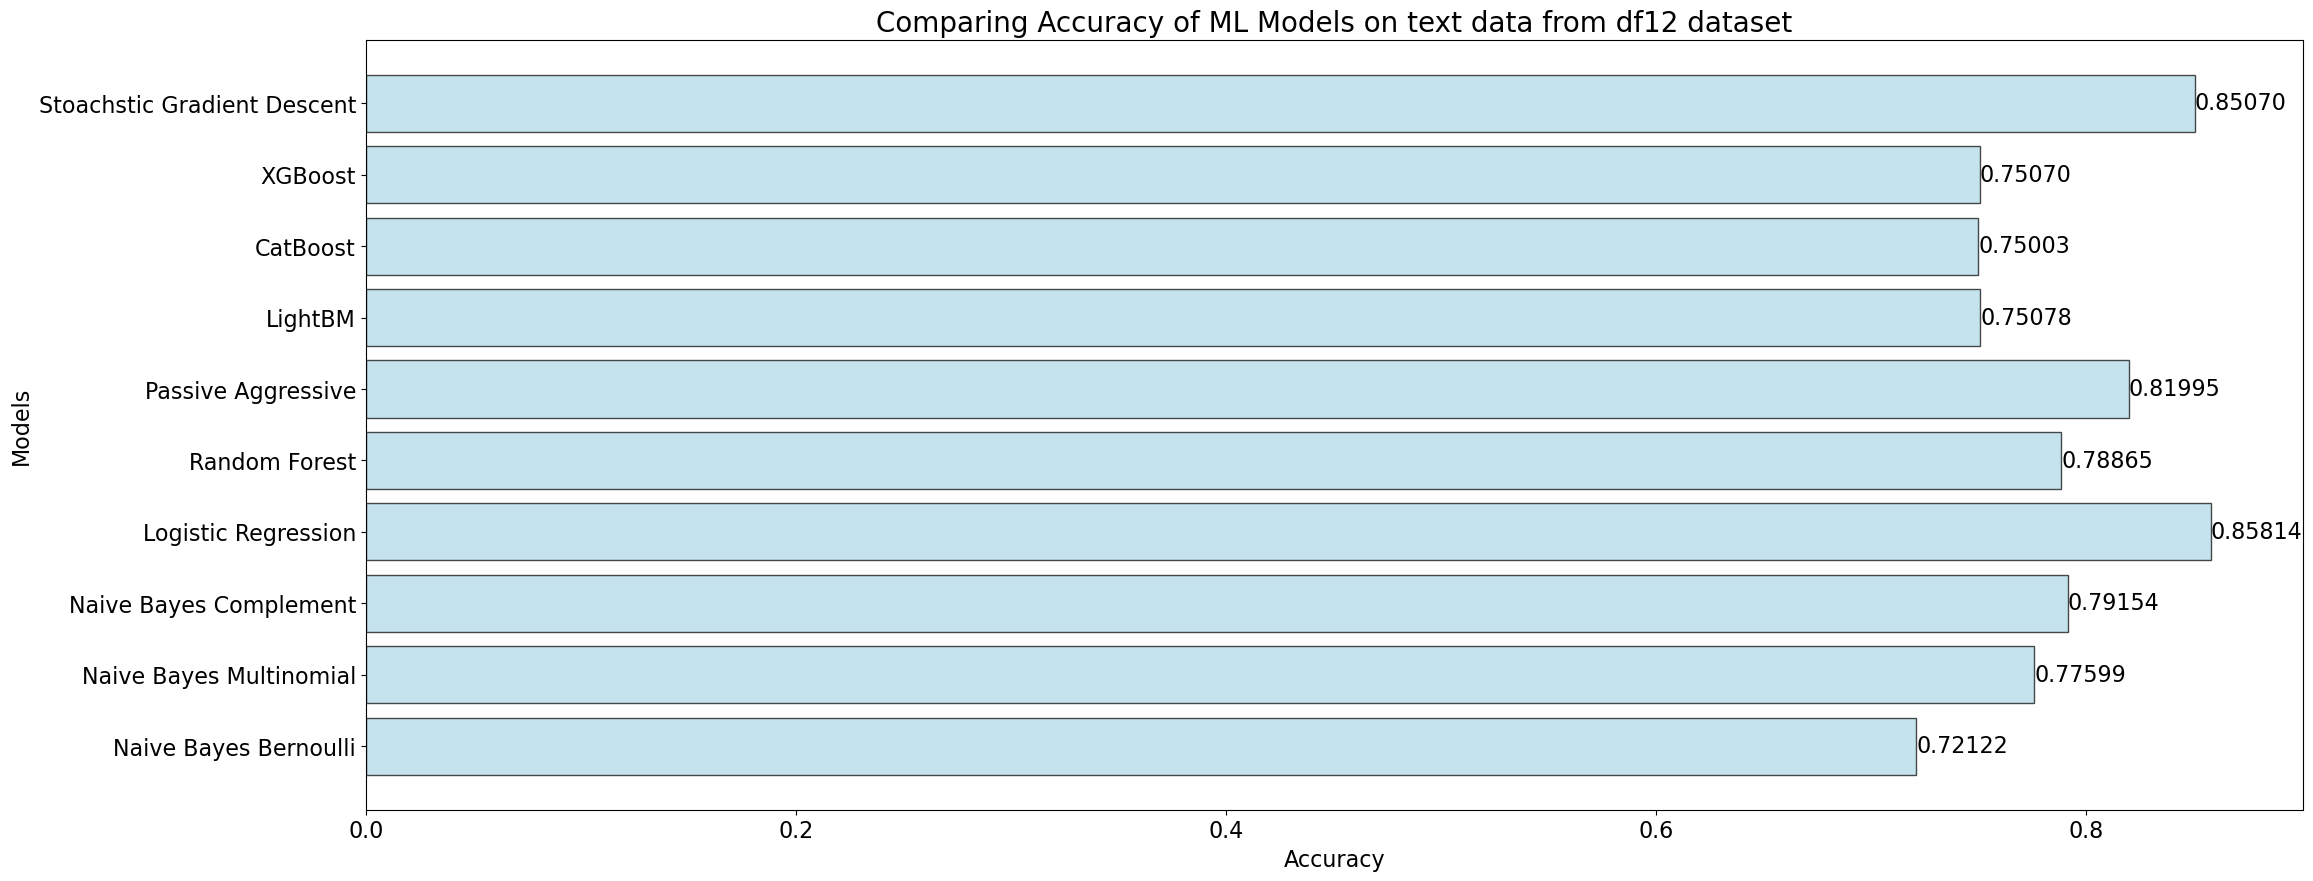

In [315]:
# Data for the chart
acc_labels_sel = list(acc_labels_df12_tfidf_sel.keys())
acc_values_sel = list(acc_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_sel, acc_values_sel, color='lightblue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 2: Accuracy of all models

In [293]:
#Creating the Dictionary with model name as key and accuracy as key-value
acc_labels_df12_tfidf_all={'Naive Bayes Bernoulli':accuracy_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':accuracy_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':accuracy_NB_Compl_df12_tfidf,
        'Logistic Regression':accuracy_LogReg_df12_tfidf,
        'Logistic Regression with class weight':accuracy_LogReg_df12_tfidf_CW,
        'Random Forest':accuracy_rf_df12_tfidf,
        'Passive Aggressive':accuracy_PassAgg_df12_tfidf,
        'Passive Aggressive with class weight':accuracy_PassAgg_df12_tfidf_CW,
        'LightBM 20 rounds':accuracy_LightGBM_df12_tfidf,
        'LightBM 200 rounds':accuracy_LightGBM_df12_tfidf_200,
        'LightBM 500 rounds':accuracy_LightGBM_df12_tfidf_500,
        'LightBM 500 rounds with class weight':accuracy_LightGBM_df12_tfidf_500_CW,
        'CatBoost 20 rounds':accuracy_CatBoost_df12_tfidf, 
        'CatBoost 50 rounds':accuracy_CatBoost_df12_tfidf_50, 
        'XGBoost 50 rounds':accuracy_XGBoost_df12_tfidf,
        'XGBoost 200 rounds':accuracy_XGBoost_df12_tfidf_200,
        'XGBoost 500 rounds':accuracy_XGBoost_df12_tfidf_500,
        'Stoachstic Gradient Descent':accuracy_sgd_df12_tfidf,
        'Stoachstic Gradient Descent with class weight':accuracy_sgd_df12_tfidf_CW} 
        


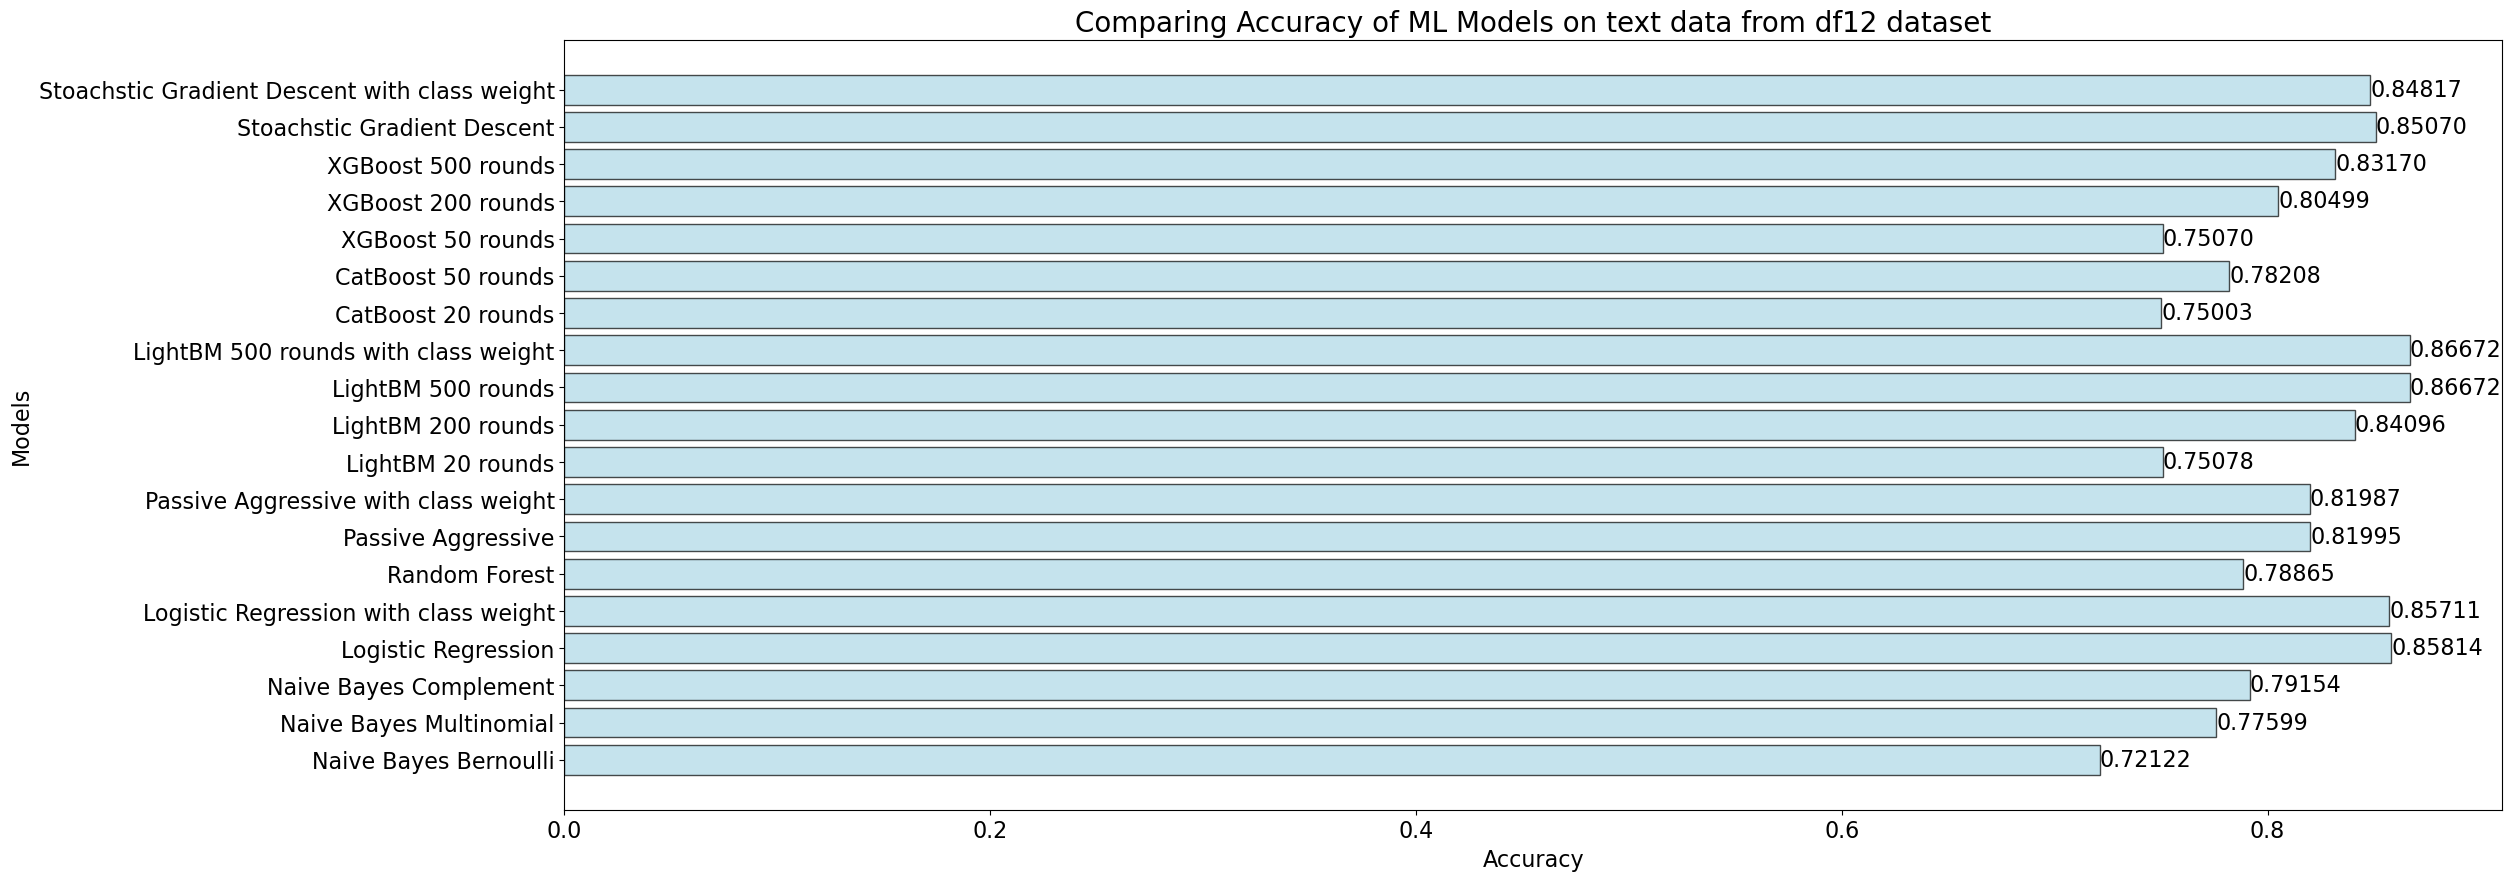

In [312]:
# Data for the chart
acc_labels_all = list(acc_labels_df12_tfidf_all.keys())
acc_values_all = list(acc_labels_df12_tfidf_all.values())
# colors=['yellow','orange','magenta', 'gray', 'lightgray', 'blue', 'black', 'darkgray', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing Accuracy of ML Models on text data from df12 dataset', fontsize=20)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(acc_labels_all, acc_values_all, color='lightblue', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(acc_values_all):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 3: f1 score of selected models

In [304]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_tfidf_sel={'Naive Bayes Bernoulli':f1_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':f1_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':f1_NB_Compl_df12_tfidf,
        'Logistic Regression':f1_LogReg_df12_tfidf,
        'Random Forest':f1_rf_df12_tfidf,
        'Passive Aggressive':f1_PassAgg_df12_tfidf,
        'LightBM':f1_LightGBM_df12_tfidf,
        'CatBoost':f1_CatBoost_df12_tfidf, 
        'XGBoost':f1_XGBoost_df12_tfidf,
        'Stoachstic Gradient Descent':f1_sgd_df12_tfidf} 
        


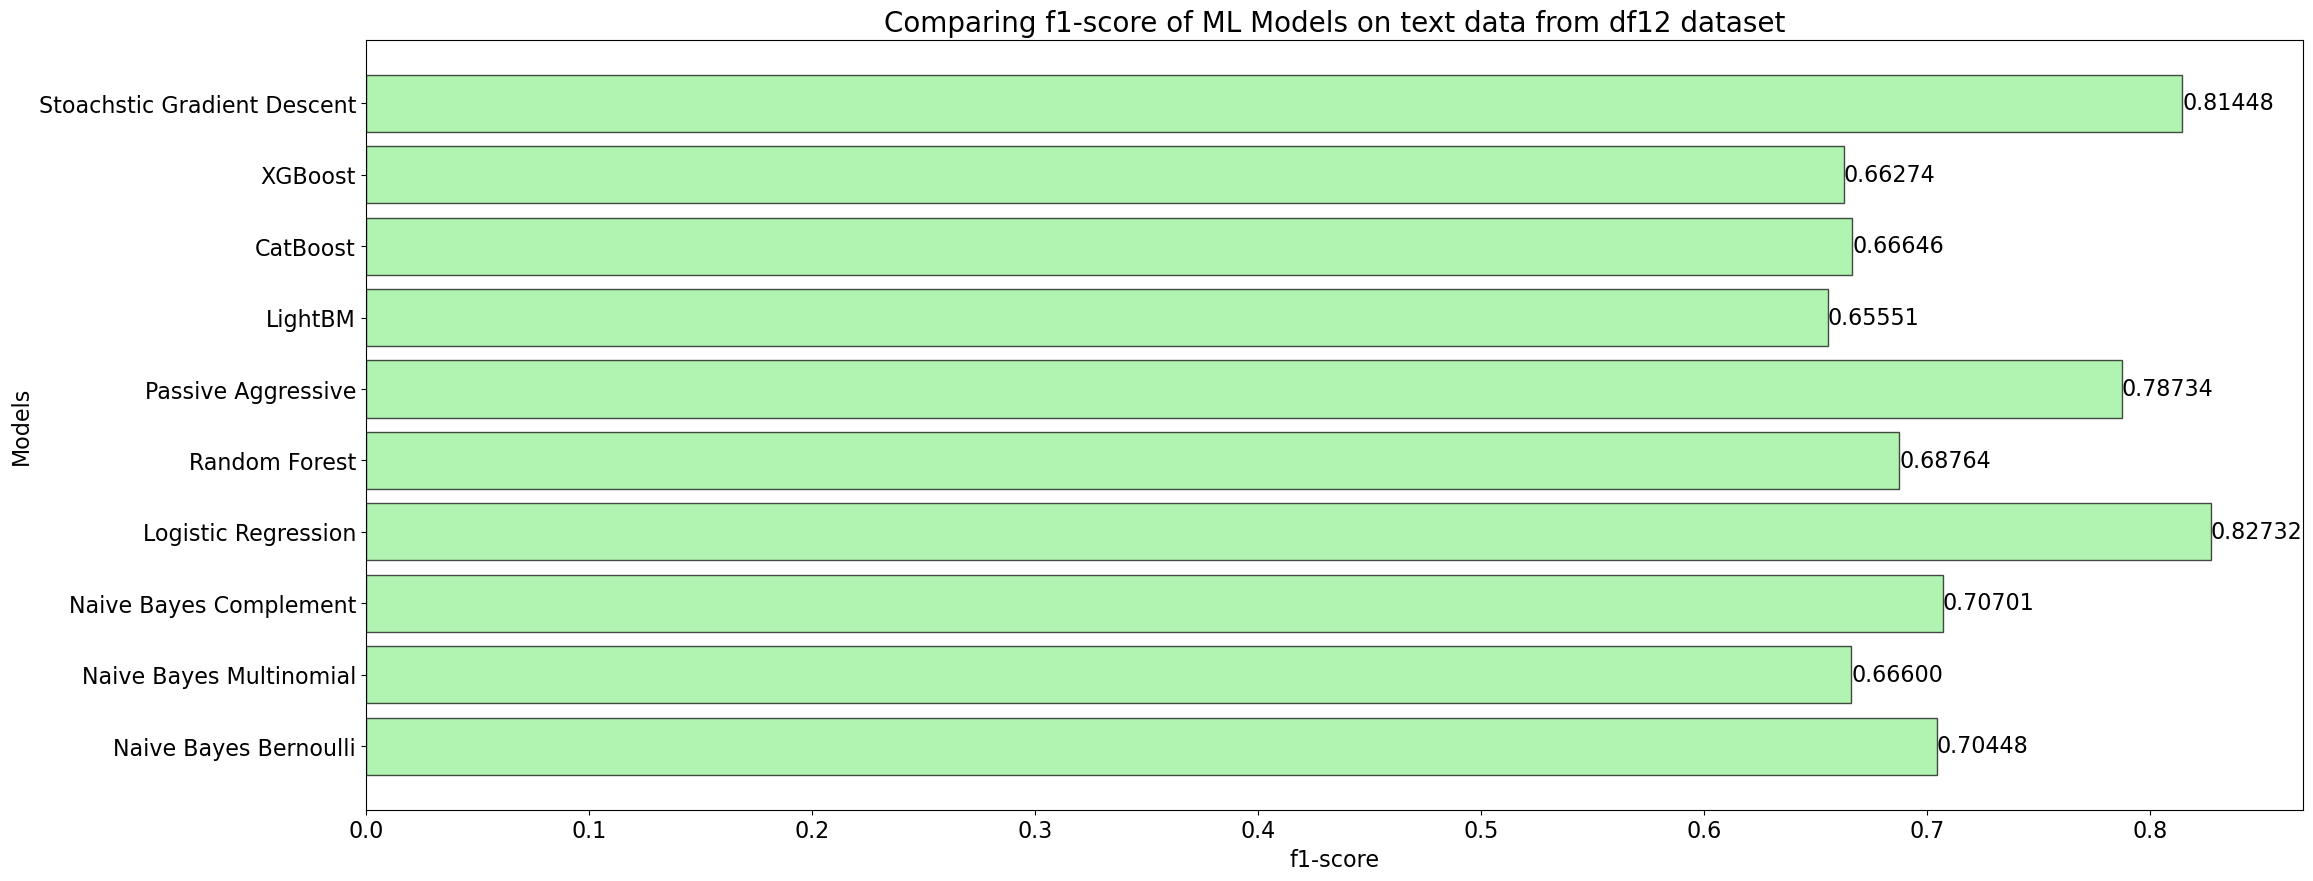

In [313]:
# Data for the chart
f1_labels_sel = list(f1_labels_df12_tfidf_sel.keys())
f1_values_sel = list(f1_labels_df12_tfidf_sel.values())
# colors=['yellow','orange','magenta', 'gray', 'blue', 'black', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_sel, f1_values_sel, color='lightgreen', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_sel):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();

## PLOT 4: f1 score of all models

In [306]:
#Creating the Dictionary with model name as key and accuracy as key-value
f1_labels_df12_tfidf_all={'Naive Bayes Bernoulli':f1_NB_Bern_df12_tfidf,
        'Naive Bayes Multinomial':f1_NB_Mult_df12_tfidf,
        'Naive Bayes Complement':f1_NB_Compl_df12_tfidf,
        'Logistic Regression':f1_LogReg_df12_tfidf,
        'Logistic Regression with class weight':f1_LogReg_df12_tfidf_CW,
        'Random Forest':f1_rf_df12_tfidf,
        'Passive Aggressive':f1_PassAgg_df12_tfidf,
        'Passive Aggressive with class weight':f1_PassAgg_df12_tfidf_CW,
        'LightBM 20 rounds':f1_LightGBM_df12_tfidf,
        'LightBM 200 rounds':f1_LightGBM_df12_tfidf_200,
        'LightBM 500 rounds':f1_LightGBM_df12_tfidf_500,
        'LightBM 500 rounds with class weight':f1_LightGBM_df12_tfidf_500_CW,
        'CatBoost 20 rounds':f1_CatBoost_df12_tfidf, 
        'CatBoost 50 rounds':f1_CatBoost_df12_tfidf_50, 
        'XGBoost 50 rounds':f1_XGBoost_df12_tfidf,
        'XGBoost 200 rounds':f1_XGBoost_df12_tfidf_200,
        'XGBoost 500 rounds':f1_XGBoost_df12_tfidf_500,
        'Stoachstic Gradient Descent':f1_sgd_df12_tfidf,
        'Stoachstic Gradient Descent with class weight':f1_sgd_df12_tfidf_CW} 
        

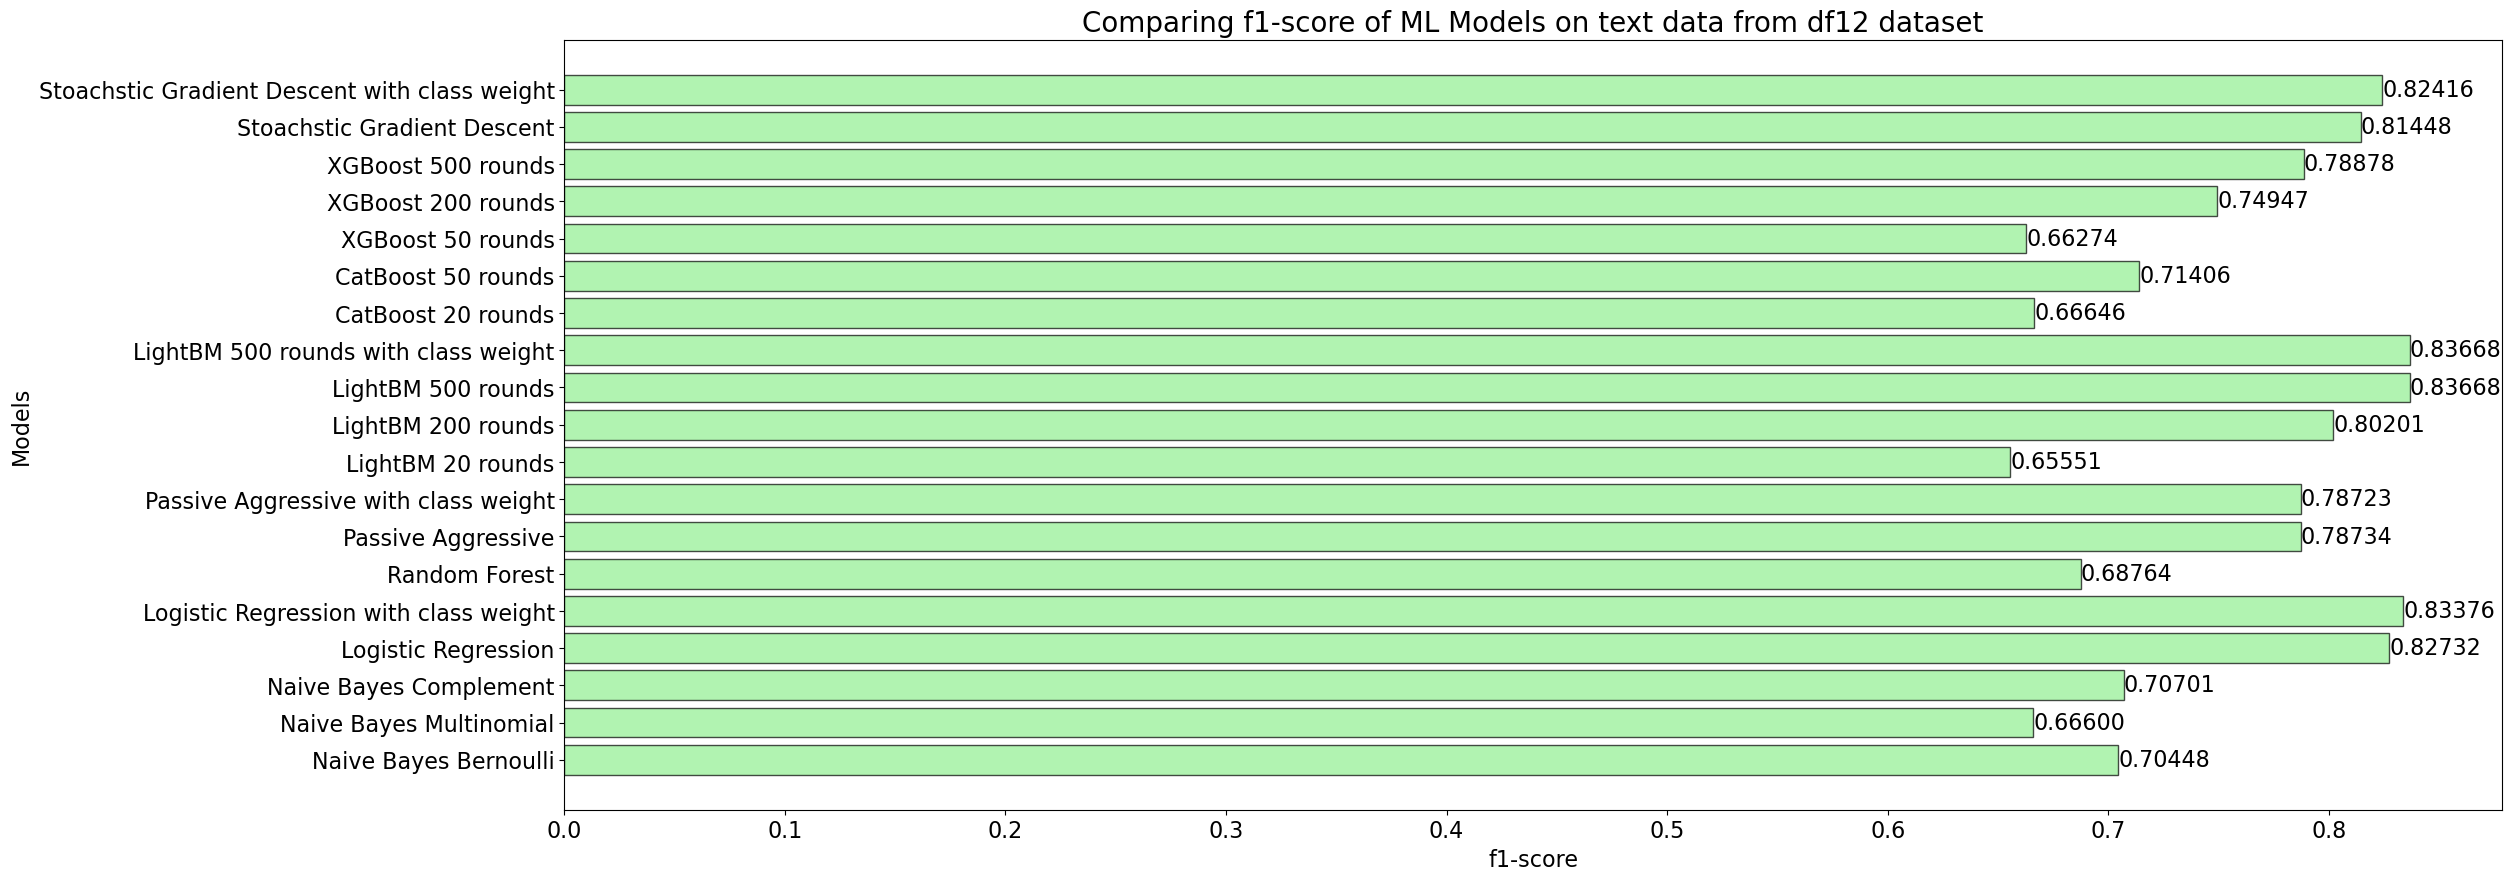

In [314]:
# Data for the chart
f1_labels_all = list(f1_labels_df12_tfidf_all.keys())
f1_values_all = list(f1_labels_df12_tfidf_all.values())
# colors=['yellow','orange','magenta', 'gray', 'lightgray', 'blue', 'black', 'darkgray', 'white', 'lightgreen', 'darkred', 'purple']

# Creating the chart
plt.figure(figsize=(25, 10))
plt.title('Comparing f1-score of ML Models on text data from df12 dataset', fontsize=20)
plt.xlabel('f1-score', fontsize=16)
plt.ylabel('Models', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)# Increase the plot width to accommodate the values

plt.barh(f1_labels_all, f1_values_all, color='lightgreen', edgecolor='black', linewidth=1, alpha=0.7)

# Displaying values at the end of the bars
for i, value in enumerate(f1_values_all):
    plt.text(value, i, f'{value:.5f}', fontsize=16, va='center')

plt.show();